## Import modules

In [1]:
import numpy as np
import itertools

# to get and read data
import os
from zipfile import ZipFile
from scipy.io import arff

# to plot the data
import matplotlib.pyplot as plt

# for neural network
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [130]:
# import python file containing functions
!pip install import_ipynb
import import_ipynb
import myfunctions

In [131]:
# to relead notebook after editing
import importlib
importlib.reload(myfunctions)

importing Jupyter notebook from myfunctions.ipynb


<module 'myfunctions' from 'myfunctions.ipynb'>

## get and read data

get data

In [5]:
# download zip
myfunctions.download_file(url = 'http://www.timeseriesclassification.com/Downloads/CharacterTrajectories.zip',
                      saveAs = 'CharacterTrajectories.zip')

# extract folder from zip
if not os.path.exists('CharacterTrajectories'):
    with ZipFile('CharacterTrajectories.zip', 'r') as zipObj:
      # Extract all the contents of zip file in current directory
      zipObj.extractall('CharacterTrajectories')
    print('folder extracted from zip')
else:
    print('zip already extracted')

file downloaded
folder extracted from zip


read data

In [6]:
# ignoring metadata at index 1, arff -> (data,meta)
train_data = arff.loadarff('CharacterTrajectories/CharacterTrajectories_TRAIN.arff')[0]
test_data = arff.loadarff('CharacterTrajectories/CharacterTrajectories_TEST.arff')[0]

max length = 182


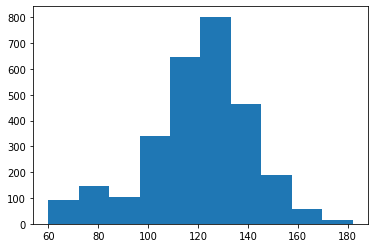

In [7]:
# Distribution of sample lenghts

lengths = []

for sample in itertools.chain(train_data,test_data):
  input = sample[0][0]
  input = np.array(list(input))
  len1 = np.where(np.isnan(input))[0][0] if any(np.isnan(input)) else len(input)
  lengths.append(len1)

print('max length =',np.max(lengths))
_ = plt.hist(lengths)

In [8]:
classes = ['a','b','c','d','e','g','h','l','m','n','o','p','q','r','s','u','v','w','y','z']
print('number of classes :',len(classes))

print('\ntrain data contains',len(train_data),'samples')
print('test data contains',len(test_data),'samples')

print('\neach sample has 3 channels : x,y and force')

number of classes : 20

train data contains 1422 samples
test data contains 1436 samples

each sample has 3 channels : x,y and force


## patches

In [9]:
train_inputs, train_labels = myfunctions.dataToPatches(train_data, window_size=20, stride=10, resizeTo=100, smooth=True, normalize=True)
test_inputs,  test_labels  = myfunctions.dataToPatches(test_data,  window_size=20, stride=10, resizeTo=100, smooth=True, normalize=True)

# subtract 1 from labels to start indexing from 0
train_labels -= 1
test_labels -= 1

create dataset and dataloader

In [10]:
train_loader, val_loader, test_loader = myfunctions.createLoaders(train_inputs, train_labels,
                                                                  test_inputs, test_labels,
                                                                  batch_size=50)

## neural network

### define network

In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 4 input channels, 6 output channels, row convolution kernel of size 3
        self.conv1 = nn.Conv1d(4, 6, 3)
        self.conv2 = nn.Conv1d(6, 16, 3)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(368, 120) 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 20)

    def forward(self, x):
        # output given by : math.floor((inp-(k-1)-1)/s+1)
        x = F.max_pool1d(F.relu(self.conv1(x)), 2)
        x = F.max_pool1d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

### create network

In [133]:
net = Net().to(device)

#Define a Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### train network

epoch: 41, train loss: 1.346, val loss: 1.407
epoch: 82, train loss: 0.789, val loss: 0.978
epoch: 123, train loss: 0.642, val loss: 0.806
epoch: 164, train loss: 0.547, val loss: 0.827
epoch: 205, train loss: 0.482, val loss: 0.901
epoch: 246, train loss: 0.419, val loss: 0.834

Finished Training


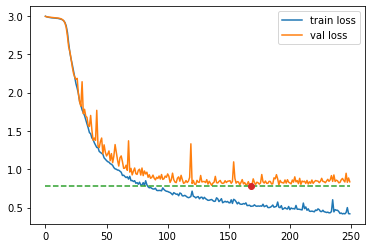

In [134]:
best_params = myfunctions.trainNet(net,criterion,optimizer, 
                                  train_loader,val_loader,
                                  epochs=250)

In [136]:
net.load_state_dict(best_params)

<All keys matched successfully>

### evaluate network

In [137]:
print("evaluation results on train data")
myfunctions.evaluate(net,train_loader,classes)
print("evaluation results on test data")
myfunctions.evaluate(net,test_loader,classes)

evaluation results on train data



              precision    recall  f1-score   support

           a     0.7456    0.8829    0.8084       760
           b     0.6555    0.6902    0.6724       623
           c     0.9343    0.9814    0.9573       377
           d     0.8407    0.8643    0.8523       641
           e     0.8635    0.9679    0.9127       686
           g     0.7907    0.7504    0.7700       589
           h     0.6902    0.6072    0.6461       499
           l     0.9861    0.9753    0.9807       365
           m     0.8448    0.8822    0.8631       611
           n     0.7359    0.6350    0.6818       474
           o     0.9018    0.8416    0.8707       524
           p     0.7106    0.7547    0.7320       579
           q     0.9127    0.9475    0.9298       629
           r     0.7220    0.7008    0.7113       478
           s     0.8623    0.9193    0.8899       545
           u     0.7494    0.6243    0.6812       527
           v     0.9900    0.9610    0.9753       513
           w     0.8470   


              precision    recall  f1-score   support

           a     0.6766    0.7510    0.7118      1000
           b     0.6050    0.6675    0.6347       842
           c     0.8772    0.9629    0.9181       512
           d     0.7475    0.8740    0.8058       857
           e     0.7953    0.9067    0.8474       900
           g     0.6549    0.5718    0.6105       780
           h     0.5950    0.5107    0.5496       656
           l     0.9809    0.9430    0.9616       491
           m     0.7790    0.7943    0.7866       812
           n     0.5776    0.5068    0.5399       661
           o     0.8453    0.8112    0.8279       694
           p     0.6453    0.6922    0.6679       770
           q     0.7991    0.8921    0.8431       834
           r     0.6199    0.5411    0.5778       645
           s     0.8545    0.8968    0.8752       727
           u     0.5493    0.4395    0.4883       735
           v     0.9297    0.9243    0.9270       687
           w     0.6787   